In [1]:
import pandas as pd
import numpy as np
import os
import time

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


import json
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark_conf = (SparkConf().setAppName('order holding').setMaster('local[32]')
            .set("spark.executor.memory", "50G")
            .set('spark.driver.memory', '50G')
            .set('spark.driver.maxResultSize', '50G'))

spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
feature = spark.read.csv("data/feature.csv", header = True)
feature_rdd = feature.rdd.repartition(1000)

In [3]:
#统计每日购买和赎回概率
def user_feature_analysis(x):

        uid = x[0]
        user_feature = pd.DataFrame([v.asDict() for v in x[1]]).fillna(np.nan)
        user_feature = user_feature.set_index(['ts_holding_uid', 'ts_date'])
        user_feature = user_feature.sort_index()
        user_feature['36'] = user_feature['36'].astype(float)
        user_feature['46'] = user_feature['46'].astype(float)
        user_feature = user_feature[['36', '46']].fillna(0.0)
        #user_feature = user_feature.rolling(window = 30).sum().dropna()
        user_feature.index = user_feature.index.droplevel(0)
        date_buy_redeem = {}
        for date in user_feature.index:
            tag_36 = max(user_feature.loc[date, '36'].ravel())
            tag_46 = max(user_feature.loc[date, '46'].ravel())
            buy_redeem = date_buy_redeem.setdefault(date, {})
            if tag_36 >= 1.0:
                buy_num = buy_redeem.setdefault('buy',0)
                buy_redeem['buy'] = buy_num + 1
            elif tag_46 >= 1.0:
                redeem_num = buy_redeem.setdefault('redeem',0)
                buy_redeem['redeem'] = redeem_num + 1
            elif (tag_36 == 0.0) and (tag_46 == 0.0):
                hold_num = buy_redeem.setdefault('hold',0)
                buy_redeem['hold'] = hold_num + 1
        return date_buy_redeem
    
    
def buy_redeem_num_reduce(log1, log2):
    for date in log1.keys():
        log2_date_buy_redeem = log2.setdefault(date, {})
        log1_date_buy_redeem = log1[date]
        for tag in log1_date_buy_redeem:
            log1_tag_num = log1_date_buy_redeem[tag]
            log2_tag_num = log2_date_buy_redeem.setdefault(tag, 0)
            log2_date_buy_redeem[tag] = log1_tag_num + log2_tag_num
    return log2

In [4]:
feature = feature_rdd.groupBy(lambda x : x.ts_holding_uid).map(user_feature_analysis).reduce(buy_redeem_num_reduce)
print('feature num', len(feature))
spark.stop()

feature num 742


In [5]:
df = pd.DataFrame(feature).T.fillna(0.0)
df = df.sort_index(ascending = False)
df = df[df.buy != 0]
df['total'] = df.buy + df.hold + df.redeem
df['buy_ratio'] = df.buy / df.total
df['redeem_ratio'] = df.redeem / df.total
#df['buy_ratio_rolling_20_mean'] = df.buy_ratio.rolling(window = 20, min_periods = 1).mean()
#df['redeem_ratio_rolling_20_mean'] = df.redeem_ratio.rolling(window = 20, min_periods = 1).mean()
df = df[df.index >= '2017-01-01']
#df.to_csv('tmp/buy_redeem_ratio.csv')
buy_redeem_ratio_df = df
buy_redeem_ratio_df.index = pd.to_datetime(buy_redeem_ratio_df.index)

In [6]:
online_nav = pd.read_csv('data/online_nav.csv', index_col = ['on_date'], parse_dates = ['on_date'])
#print(online_nav)

In [7]:
buy_redeem_ratio_nav_df = pd.concat([buy_redeem_ratio_df, online_nav], axis = 1, join_axes = [buy_redeem_ratio_df.index])

In [10]:
buy_redeem_ratio_nav_df.to_csv('tmp/buy_redeem_ratio_nav.csv')
buy_redeem_ratio_nav_df.head(20)
print(np.corrcoef(buy_redeem_ratio_nav_df.redeem_ratio, buy_redeem_ratio_nav_df.risk10.pct_change().fillna(0.0)))
print(np.corrcoef(buy_redeem_ratio_nav_df.buy_ratio, buy_redeem_ratio_nav_df.risk10.pct_change().fillna(0.0)))
buy_redeem_ratio_nav_df[buy_redeem_ratio_nav_df.index < '2018-02-01'].buy_ratio.mean()
buy_redeem_ratio_nav_df.buy_ratio.mean()

[[1.         0.03895309]
 [0.03895309 1.        ]]
[[1.         0.07072433]
 [0.07072433 1.        ]]


0.03230495921716488

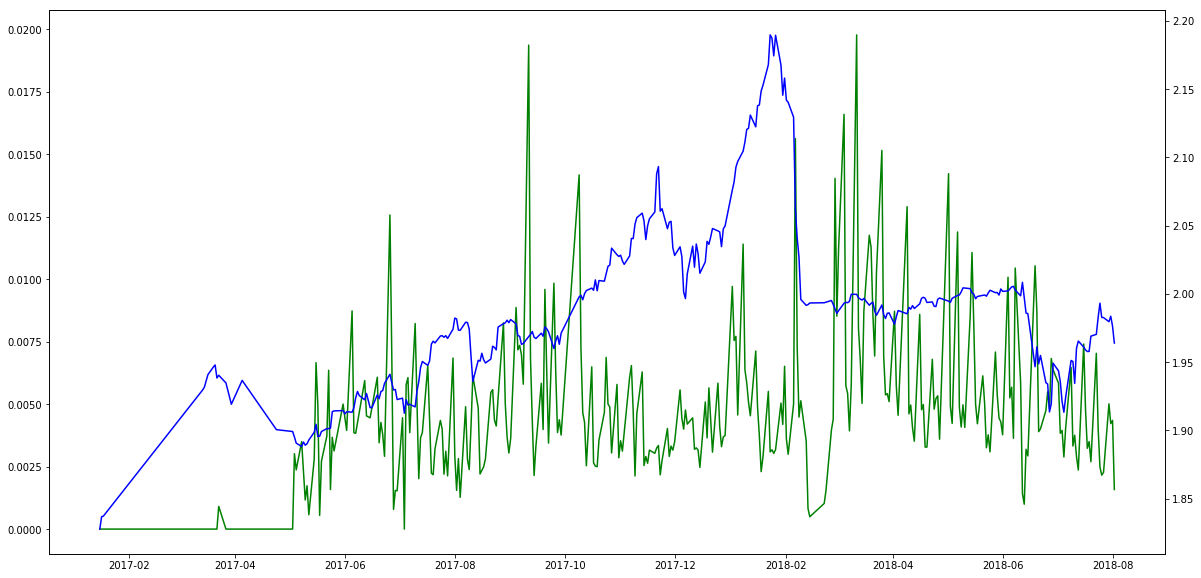

In [9]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(buy_redeem_ratio_nav_df.redeem_ratio, 'g')
ax2.plot(buy_redeem_ratio_nav_df.risk10 ,'b')
plt.show()

In [9]:
data = []
for i in range(3, 480):
    buy_redeem_ratio_nav_df['risk10_pct'] = buy_redeem_ratio_nav_df.risk10.pct_change().fillna(0.0).rolling(window = i, min_periods = 1).mean()
    #print(i, buy_redeem_ratio_nav_df.corr().loc['risk10_pct', ['buy_ratio', 'redeem_ratio']].ravel())
    data.append(buy_redeem_ratio_nav_df.corr().loc['risk10_pct', ['buy_ratio', 'redeem_ratio']].tolist())
df = pd.DataFrame(data, index = range(3, 480))
df.to_csv('tmp/buy_redeem_ratio_return.csv')

In [1]:
import pandas as pd
import numpy as np
import os
import time

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


import json
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import random
import matplotlib.pyplot as plt
%matplotlib inline


spark_conf = (SparkConf().setAppName('order holding').setMaster('local[32]')
            .set("spark.executor.memory", "50G")
            .set('spark.driver.memory', '50G')
            .set('spark.driver.maxResultSize', '50G'))

spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
feature = spark.read.csv("data/feature.csv", header = True)
feature_rdd = feature.rdd.repartition(1000)

In [2]:
#统计持有相同天数的用户的购买和赎回率
def user_feature_analysis(x):

        uid = x[0]
        user_feature = pd.DataFrame([v.asDict() for v in x[1]]).fillna(np.nan)
        user_feature = user_feature.set_index(['ts_holding_uid', 'ts_date'])
        user_feature = user_feature.sort_index()
        user_feature['36'] = user_feature['36'].astype(float)
        user_feature['46'] = user_feature['46'].astype(float)
        user_feature = user_feature[['36', '46', 'ts_nav', 'ts_asset']].fillna(0.0)
        #user_feature = user_feature.rolling(window = 30).sum().dropna()
        user_feature.index = user_feature.index.droplevel(0)
        date_buy_redeem = {}
        for i in range(0, len(user_feature.index)):
            date = user_feature.index[i]
            tag_36 = max(user_feature.loc[date, '36'].ravel())
            tag_46 = max(user_feature.loc[date, '46'].ravel())
            buy_redeem = date_buy_redeem.setdefault(i, {})
            if tag_36 >= 1.0:
                buy_num = buy_redeem.setdefault('buy',0)
                buy_redeem['buy'] = buy_num + 1
            elif tag_46 >= 1.0:
                redeem_num = buy_redeem.setdefault('redeem',0)
                buy_redeem['redeem'] = redeem_num + 1
            elif (tag_36 == 0.0) and (tag_46 == 0.0):
                hold_num = buy_redeem.setdefault('hold',0)
                buy_redeem['hold'] = hold_num + 1
        return date_buy_redeem
    
    
def buy_redeem_num_reduce(log1, log2):
    for date in log1.keys():
        log2_date_buy_redeem = log2.setdefault(date, {})
        log1_date_buy_redeem = log1[date]
        for tag in log1_date_buy_redeem:
            log1_tag_num = log1_date_buy_redeem[tag]
            log2_tag_num = log2_date_buy_redeem.setdefault(tag, 0)
            log2_date_buy_redeem[tag] = log1_tag_num + log2_tag_num
    return log2

In [3]:
feature = feature_rdd.groupBy(lambda x : x.ts_holding_uid).map(user_feature_analysis).reduce(buy_redeem_num_reduce)
print('feature num', len(feature))
spark.stop()

feature num 756


In [20]:
df = pd.DataFrame(feature).T.fillna(0.0)
df = df.sort_index(ascending = True)
df = df[df.buy != 0]
df = df.iloc[1:]
df['total'] = df.buy + df.hold + df.redeem
df['buy_ratio'] = df.buy / df.total
df['redeem_ratio'] = df.redeem / df.total
df = df[df.total >= 5000]
df.tail()

,buy,hold,redeem,total,buy_ratio,redeem_ratio
310,39.0,5243.0,14.0,5296.0,0.007364,0.002644
311,50.0,5168.0,9.0,5227.0,0.009566,0.001722
312,40.0,5049.0,17.0,5106.0,0.007834,0.003329
313,54.0,4996.0,17.0,5067.0,0.010657,0.003355
314,58.0,4982.0,12.0,5052.0,0.011481,0.002375


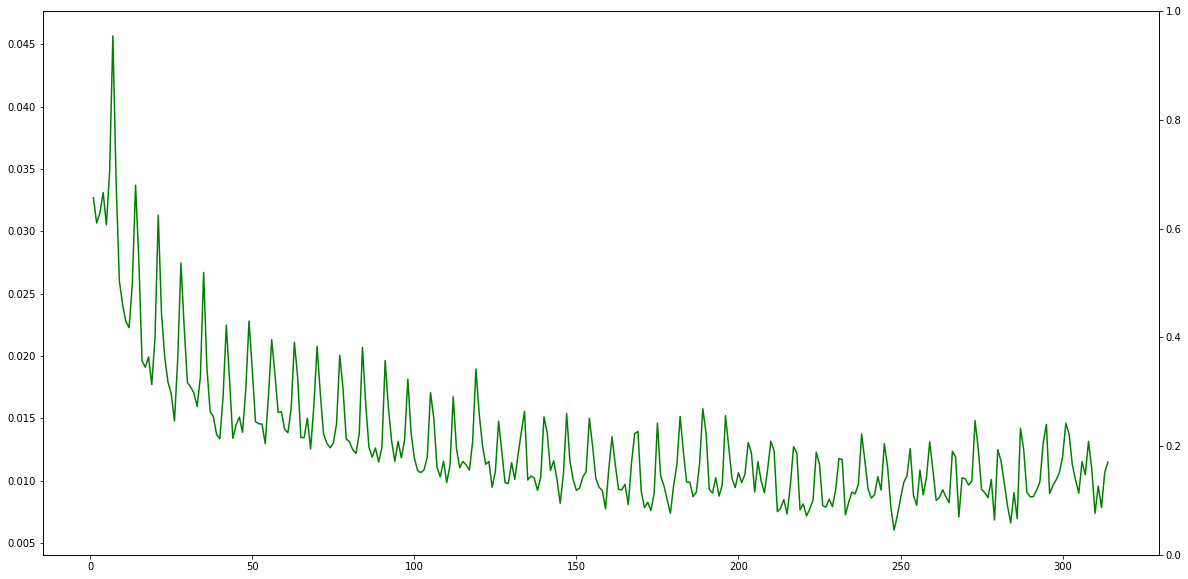

In [21]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
ax1.plot(df.buy_ratio, 'g')
#ax2.plot(df.risk10.pct_change().fillna(0.0).rolling(20).sum(), 'b')
plt.show()

In [1]:
import pandas as pd
import numpy as np
import os
import time

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


import json
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import random
import matplotlib.pyplot as plt
import functools
%matplotlib inline


spark_conf = (SparkConf().setAppName('order holding').setMaster('local[32]')
            .set("spark.executor.memory", "50G")
            .set('spark.driver.memory', '50G')
            .set('spark.driver.maxResultSize', '50G'))

spark = SparkSession.builder.config(conf = spark_conf).getOrCreate()
feature = spark.read.csv("data/feature_log.csv", header = True)
feature_rdd = feature.rdd.repartition(1000)
trade_dates = pd.read_csv('data/trade_dates.csv', index_col = ['td_date'], parse_dates = ['td_date'])
index_sh = pd.read_csv('data/index_sh.csv', index_col = ['ra_date'], parse_dates = ['ra_date'])
print(trade_dates.tail())
print(index_sh.tail())

            td_type
td_date            
2018-06-29       10
2018-08-31       10
2001-04-30       11
2007-04-30       11
2013-09-30       11
              ra_nav
ra_date             
1997-07-18  1209.857
1997-07-17  1197.226
1997-07-16  1190.826
1997-07-15  1200.114
1997-07-14  1185.720


In [2]:
#构建用户特征用于分析
def user_feature_analysis(trade_dates, index_sh, x):

        uid = x[0]
        user_feature = pd.DataFrame([v.asDict() for v in x[1]]).fillna(np.nan)
        user_feature['date'] = pd.to_datetime(user_feature.date)
        user_feature = user_feature[user_feature.date.isin(trade_dates.index)]
        user_feature = user_feature.set_index(['uid', 'date'])
        user_feature = user_feature.sort_index()
        index_sh = index_sh.sort_index()
        
        
        info_cols = ['ts_nav', 'ts_asset', 'ts_profit', 'ts_risk']
        for col in info_cols:
            user_feature[col] = user_feature[col].astype(np.float32)
            user_feature[col] = user_feature[col].fillna(method = 'pad')
        buy_redeem_cols = [ '36', '46', '56', '66']
        for col in buy_redeem_cols:
            user_feature[col] = user_feature[col].astype(np.float32)
            user_feature[col] = user_feature[col].fillna(0.0)
        
        log_cols = ['page_id=2006', 'page_id=2013', 'page_id=2032', 'page_id=2161', 'page_id=3078', 'ref_id=2006&page_id=2138&ctrl=3',\
                'ref_id=2006&page_id=2139&ctrl=2&oid=1', 'ref_id=2006&page_id=2141&ctrl=2&oid=3', 'ref_id=2006&page_id=2142&oid=4', \
                'ref_id=2006&page_id=2143&ctrl=2&oid=5', 'ref_id=2006&page_id=2146&ctrl=2&oid=2',\
                'ref_id=2013&page_id=2126&ctrl=8&oid=20', 'ref_id=2013&page_id=2127&ctrl=3&oid=20', \
                'ref_id=2013&page_id=2133&ctrl=4&oid=20', 'ref_id=2013&page_id=2148&ctrl=1&oid=20', \
                'ref_id=2013&page_id=2150&ctrl=2&oid=20', 'ref_id=2013&page_id=2154&ctrl=5&oid=20',\
                'ref_id=2013&page_id=2171&ctrl=9&oid=20', 'ref_id=2138&page_id=2110&ctrl=2', 'ref_id=2147']
        
        for col in log_cols:
            user_feature[col] = user_feature[col].astype(np.float32)
            user_feature[col] = user_feature[col].fillna(0.0)
        
        tag = np.zeros(len(user_feature))
        
        #二类分类研究赎回
        tag[user_feature['36'] == 1.0] = 0
        tag[user_feature['46'] == 1.0] = 1.0
        
        user_feature['tag'] = tag
        user_feature['tag'] = user_feature.tag.shift(-1)
        user_feature = user_feature.iloc[0:-1]
             
        #print(user_feature[user_feature.tag == 1][['36', 'tag']])    
        
        #print(user_feature.columns)
        
        user_feature = user_feature[['ts_nav', 'ts_asset', 'tag', '36', '46', '56', '66', 'ts_profit', 'ts_risk'] + log_cols].fillna(0.0)
        
        user_feature['inc'] = user_feature.ts_nav.pct_change().fillna(0.0)
        
        index_sh = index_sh.loc[user_feature.index.get_level_values(1)]
        index_sh_inc = index_sh.pct_change().fillna(0.0)
        user_feature['inc_minus_sh'] = user_feature.inc.ravel() - index_sh_inc.ra_nav.ravel()
        user_feature['index_sh_inc'] = index_sh_inc.ra_nav.ravel()
        
        user_feature['days'] = np.arange(1, len(user_feature) + 1)
        
        
        days = [5, 10, 20, 60, 120, 200, 300]
        
        for day in days:
            
            user_feature['inc_%dd' % day] = user_feature.ts_nav.pct_change(day).fillna(0.0).astype(np.float32)
            user_feature['std_%dd' % day] = user_feature.ts_nav.pct_change().rolling(day).std().fillna(0.0).astype(np.float32)
            user_feature['shape_%dd' % day] = (user_feature['inc_%dd' % day] / user_feature['std_%dd' % day]).fillna(0.0).astype(np.float32)
            
            user_feature['sh_inc_%dd' % day] = user_feature.index_sh_inc.rolling(day).mean().fillna(0.0).astype(np.float32)
            user_feature['sh_std_%dd' % day] = user_feature.index_sh_inc.rolling(day).std().fillna(0.0).astype(np.float32)
            user_feature['sh_shape_%dd' % day] = (user_feature['sh_inc_%dd' % day] / user_feature['sh_std_%dd' % day]).fillna(0.0).astype(np.float32)
            
            user_feature['inc_minus_sh_%dd' % day] = user_feature.inc_minus_sh.rolling(day).mean().fillna(0.0).astype(np.float32)
            user_feature['inc_minus_sh_std_%dd' % day] = user_feature.inc_minus_sh.rolling(day).std().fillna(0.0).astype(np.float32)
            
            user_feature['36_%dd' % day] = user_feature['36'].rolling(day).sum().fillna(0.0).astype(np.float32)
            user_feature['46_%dd' % day] = user_feature['46'].rolling(day).sum().fillna(0.0).astype(np.float32)
            user_feature['56_%dd' % day] = user_feature['56'].rolling(day).sum().fillna(0.0).astype(np.float32)
            user_feature['66_%dd' % day] = user_feature['66'].rolling(day).sum().fillna(0.0).astype(np.float32)
            
            user_feature['ts_profit_%dd' % day] = user_feature['ts_profit'].rolling(day).sum().fillna(0.0).astype(np.float32)
        
            for log_col in log_cols:
                user_feature['log_col' + '_%dd' % day] = user_feature[log_col].rolling(day).mean().fillna(0.0).astype(np.float64)
            #print(user_feature['log_col' + '_%dd' % day])
        
        
        #user_feature['hold_days'] = np.arange(0, len(user_feature))
        
        cols = list(user_feature)
        cols.pop(cols.index('tag'))
        cols.append('tag')
        user_feature = user_feature[cols]
                
        return user_feature.values.tolist()

    
def user_feature_reduce(u1, u2):
    return u1 + u2

In [3]:
data = feature_rdd.groupBy(lambda x : x.uid).map(functools.partial(user_feature_analysis, trade_dates, index_sh)).reduce(user_feature_reduce)
print('data num', len(data))
spark.stop()

data num 3929201


In [4]:
#random.shuffle(data)
#print('Done')
data_array = np.array(data)
print('Done')

Done


In [5]:
X = data_array[:,:-1]
Y = data_array[:,-1]

In [6]:
len(Y[Y == 1.0])

157535

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.datasets import dump_svmlight_file

#X = StandardScaler().fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=11, shuffle = True)
#X_train, X_test, y_train, y_test = X[0:int(len(X)*0.8)], X[int(len(X)*0.8):], Y[0:int(len(Y)*0.8)], Y[int(len(Y)*0.8):]
#X_train, X_val, y_train, y_val = X_train[0:int(len(X_train)*0.75)], X_train[int(len(X_train)*0.75):], y_train[0:int(len(y_train)*0.75)], \
#                                y_train[int(len(y_train)*0.75):]
#ss = StandardScaler()
#ss.fit(X_train)
#X_train = ss.transform(X_train)
#X_test = ss.transform(X_test)
#X_val = ss.transform(X_val)
print('Done')
print(len(X_train))
print(len(X_val))
print(len(X_test))
#dump_svmlight_file(X_train,y_train,'tmp/train_svmlight.dat',zero_based=True,multilabel=False)
#dump_svmlight_file(X_test,y_test,'tmp/test_svmlight.dat',zero_based=True,multilabel=False)
#dump_svmlight_file(X_val,y_val,'tmp/val_svmlight.dat',zero_based=True,multilabel=False)

Done
2357520
785840
785841


In [9]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
len(y_train[y_train == 0])
#len(y_train[y_train == 1])

2262474

In [11]:
param = {'max_depth': 3,
         'eta': 0.1, 
         'silent': 1, 
         'objective': 'binary:logistic',
         'lambda':1,
         'subsample':0.5,
         'scale_pos_weight': 1.0 * len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        }
param['nthread'] = 32
param['eval_metric'] = 'auc'
evallist = [(dtrain,'train'),(dval, 'val')]

In [ ]:
num_round = 10000
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=50)
#bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.95583	val-auc:0.955207
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 50 rounds.
[1]	train-auc:0.955868	val-auc:0.955232
[2]	train-auc:0.956965	val-auc:0.956459
[3]	train-auc:0.95837	val-auc:0.958065
[4]	train-auc:0.958691	val-auc:0.958272
[5]	train-auc:0.958907	val-auc:0.958543
[6]	train-auc:0.958918	val-auc:0.95855
[7]	train-auc:0.959169	val-auc:0.958791
[8]	train-auc:0.959245	val-auc:0.958867
[9]	train-auc:0.959617	val-auc:0.959278
[10]	train-auc:0.959967	val-auc:0.959578
[11]	train-auc:0.960381	val-auc:0.96016
[12]	train-auc:0.960545	val-auc:0.960315
[13]	train-auc:0.960764	val-auc:0.960595
[14]	train-auc:0.96071	val-auc:0.960569
[15]	train-auc:0.960738	val-auc:0.960593
[16]	train-auc:0.96085	val-auc:0.960691
[17]	train-auc:0.960979	val-auc:0.960863
[18]	train-auc:0.961206	val-auc:0.960871
[19]	train-auc:0.961073	val-auc:0.960824
[20]	train-auc:0.96109	val-auc:0.960746
[21]	train-auc:0.

In [ ]:
y_pred = bst.predict(dtest)

In [ ]:
pred = y_pred.copy()
threshold = 0.5
pred[pred >= threshold] = 1.0
pred[pred <= threshold] = 0.0
print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=['hold_buy', 'redeem'], digits = 6))
print(len(pred[pred == 0.0]))
print(len(pred[pred == 1.0]))
print(len(y_test[y_test == 0.0]))
print(len(y_test[y_test == 1.0]))